In [73]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import matplotlib as plt
import seaborn as sns
from random import randint, choice
from os import path
from main_data import (
    key_to_camelot,
    add_features,
    get_playlist,
    get_friendly,
    json_to_df,
    sp,
)


In [18]:
# Import DataFrames generated by main_data.py
def import_all():
    (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    ) = json_to_df(
        "all_streams.json",
        "music_streams_no_features.json",
        "music_streams.json",
        "no_skip_df.json",
        "playlist_example.json",
        "podcasts.json",
        "wheel_df.json",
    )
    return all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df

# todo: move to main

def hpm_rollback(pod):
    # refactoring of hpm() that works with pandas 1.4.2
    pod.loc[:, "hours"] = pod.loc[:, "playtime_s"].copy() / 3600
    pod.index = pod.timestamp
    podm = (
        pod.copy()
        .loc[:, "hours"]
        .resample("M")
        .apply(lambda x: np.sum(x.values))
        .round()
    )
    podm_gb = (
        podm.groupby(podm.index.strftime("%b"))
        .resample("Y")
        .apply(lambda x: np.sum(x.values))
        .round()
        .droplevel(level=1)
    )
    podm_gb = podm_gb.groupby(podm_gb.index).mean()
    return podm_gb


def hpm(df):
    df.loc[:, "hours"] = df.loc[:, "playtime_s"].copy() / 3600
    df = df.groupby(['month', pd.Grouper(key='timestamp', freq='Y')])['playtime_s'].sum().groupby("month").mean()
    return df

def plthpm(sgb):
    return sns.barplot(data=sgb.iloc[0:0], x=sgb.values, y=sgb.index)

# def plothpm(
#     plt.rcParams["figure.figsize"] = (8, 8)
# sns.barplot(data=podm_gb, x=podm_gb["hours"], y=podm_gb.index)
# )


def top_songs(years="all", skips=False, features=True):
    if skips and features:
        df = music_streams
    elif not skips:
        df = df.query("(playtime_s / duration_s) > 0.51").reset_index()
    # todo complete this

def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)

In [19]:
all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df = import_all()

In [20]:
all_streams

,timestamp,playtime_s,track,artist,album,id,episode,show,spotify_episode_uri,shuffle,date,month,year,day
0,2021-03-25 18:43:26,351,Throw Some D's Remix,Rich Boy,Rich Boy,1qXLj4ywjsA0hGmaibmnn3,None,None,None,False,2021-03-25,Mar,2021,Thu
1,2022-01-18 16:50:55,3141,None,None,None,None,178 – Joy of Cooking (Pies),Sleepy,spotify:episode:6Y7GtYpMqhGMkjp84Tbb2o,False,2022-01-18,Jan,2022,Tue
2,2019-12-05 05:13:00,158,Bounce,Latto,Big Latto,45anQ4WSf2a9QhZq55aaMw,None,None,None,False,2019-12-05,Dec,2019,Thu
3,2019-12-07 08:21:03,263,"Can't Stop, Won't Stop",Young Gunz,Tough Luv,1kgDlypHy9hCvCxeoCtd7X,None,None,None,False,2019-12-07,Dec,2019,Sat
4,2021-09-17 03:23:34,44,Douha (Mali Mali),Disclosure,ENERGY,33J9lmeViWXN0Le0vWRyjc,None,None,None,False,2021-09-16,Sep,2021,Thu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89268,2022-01-27 00:42:30,23,Nonstop Feeling,Mall Grab,Steel City Dance Discs Volume 20,2oQVKWHh7FpdPtQkqt3kMc,None,None,None,False,2022-01-26,Jan,2022,Wed
89269,2020-10-11 19:29:48,263,Next Levels,King Geedorah,Take Me To Your Leader,58MeeOMk6PMQxXWY9YCNPD,None,None,None,False,2020-10-11,Oct,2020,Sun
89270,2022-08-29 08:30:37,454,The Frontier,Avalon Emerson,Whities 006,4qpY8nTiATIzPZ8eMucSID,None,None,None,True,2022-08-29,Aug,2022,Mon
89271,2021-10-03 07:36:02,1,La vita nuova,Christine and the Queens,La vita nuova,36LC0XouPxisV5wz8I0fZ9,None,None,None,True,2021-10-03,Oct,2021,Sun


In [21]:

music_streams# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.
why_tala = music_streams_no_features#.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.loc[:, ['playtime_s', 'timestamp']].groupby(by=why_tala.timestamp.dt.hour)
    .sum(numeric_only=True)
    .sort_values(by="playtime_s", ascending=False))
why_why_tala["playtime_s"] = why_why_tala["playtime_s"].apply(lambda x: x / 3600)
why_why_tala.head(50)


,playtime_s
timestamp,
5,217.660833
6,213.599722
7,200.713056
4,195.744722
9,177.740278
3,176.846111
2,174.491389
8,172.493056
10,161.819167


In [22]:
# Looks like I just let her run on most popular song repeat for a few hours.
music_streams_no_features.query('date == "11/27/2019"').sort_values(by="timestamp")


,timestamp,playtime_s,track,artist,album,id,shuffle,date,month,year,day
78510,2019-11-27 05:00:06,162,Blue,Hope Tala,Blue,2jNdYJVaPnG3I4XJApXnZy,False,2019-11-27,Nov,2019,Wed
54104,2019-11-27 05:03:07,181,Valentine,Hope Tala,Starry Ache,4JoDBcODOajOx3ZRQlSa7o,False,2019-11-27,Nov,2019,Wed
42212,2019-11-27 05:06:13,185,Sunburn,Hope Tala,Sensitive Soul,5jjTld8YpUHmBbr4SDYmo8,False,2019-11-27,Nov,2019,Wed
83689,2019-11-27 05:08:18,122,Summer in Paris (Interlude),Hope Tala,Starry Ache,2XsYOvhSLUWgCTM10aZ4CV,False,2019-11-27,Nov,2019,Wed
60470,2019-11-27 05:11:51,213,Eden,Hope Tala,Starry Ache,6ryhckbki35oQU9AS01JWI,False,2019-11-27,Nov,2019,Wed
...,...,...,...,...,...,...,...,...,...,...,...
10584,2019-11-27 22:22:51,207,This Life,Denzel Curry,Imperial,2aQwdBWk4vSPWk1Csgtzdo,False,2019-11-27,Nov,2019,Wed
44184,2019-11-27 22:26:54,243,Zenith,Denzel Curry,Imperial,67T0J1IDGgRwNMp3vWYaVb,False,2019-11-27,Nov,2019,Wed
84067,2019-11-27 22:30:50,236,Good Night,Denzel Curry,Imperial,6bcnokzOVQxpn0quzHj6vc,False,2019-11-27,Nov,2019,Wed
35559,2019-11-28 01:32:49,87,If Tomorrow's Not Here,Denzel Curry,Imperial,3oy9CClx1zCGnhzse9AvDu,False,2019-11-27,Nov,2019,Wed


In [23]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2019-09-30,16:57:11,16:57:11,1569801600000,Mon,Sep,2019,119,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,449,2022-05-28,07:32:59,07:32:59,1653696000000,Sat,May,2022,119,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-09-05,03:45:02,03:45:02,1630800000000,Sun,Sep,2021,119,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-05-28,19:22:10,19:22:10,1622160000000,Fri,May,2021,119,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-07-16,20:09:49,20:09:49,1626393600000,Fri,Jul,2021,119,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,199,2022-02-20,22:14:35,22:14:35,1645315200000,Sun,Feb,2022,106,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,220,2019-11-24,20:48:15,20:48:15,1574553600000,Sun,Nov,2019,122,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,435,2022-02-21,18:36:48,18:36:48,1645401600000,Mon,Feb,2022,134,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,417,2020-01-24,23:56:07,23:56:07,1579824000000,Fri,Jan,2020,84,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07


In [24]:
def randyear(df):
    return choice(range(music_streams_no_features.timestamp.dt.year.min(), 
                        music_streams_no_features.timestamp.dt.year.max() +1))

In [25]:
music_streams

,artist,track,album,duration,playtime_s,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-03-25,Thu,Mar,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,156,2021-08-07,Sat,Aug,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-08-07 05:06:29
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-01-21,Thu,Jan,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,0,2019-10-18,Fri,Oct,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 18:04:48
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,2,2022-02-17,Thu,Feb,2022,161,12A,D-flat minor,True,1qXLj4ywjsA0hGmaibmnn3,2022-02-17 11:15:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85407,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,236,2022-09-29,Thu,Sep,2022,100,6B,B-flat major,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58
85408,Teitanblood,Anteinfierno,Death,297,297,2021-09-24,Fri,Sep,2021,101,6A,G minor,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37
85409,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,192,2019-12-05,Thu,Dec,2019,112,11B,A major,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04
85410,Master P,Meal Ticket,I'm Bout It,244,244,2021-01-18,Mon,Jan,2021,152,10B,D major,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48


In [26]:
music_streams.sort_values(by="playtime_s")

,artist,track,album,duration,playtime_s,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp
47809,Ludwig van Beethoven,"Piano Sonata No. 11 In B Flat Major, Op. 22: 4...",Beethoven: The Piano Sonatas,371,0,2020-04-04,Sat,Apr,2020,131,6B,B-flat major,False,4W1CenpP9ZxvSwhRHkgVF6,2020-04-04 14:15:08
3782,Main Source,Just a Friendly Game of Baseball - 2017 Remast...,Breaking Atoms,202,0,2021-05-07,Fri,May,2021,94,11A,F-sharp minor,False,3gI4WHUyXCP96IQb9hzxnJ,2021-05-07 14:13:54
16421,Aphex Twin,Nanou2,Drukqs,205,0,2020-01-04,Sat,Jan,2020,93,4B,A-flat major,False,6Wei2NUSG66WzLiqSuQAy5,2020-01-04 05:15:09
82851,Sasha Carassi,Nomads,Kill The Monster EP,416,0,2022-04-15,Fri,Apr,2022,122,12A,D-flat minor,False,6z8CNKl6hK2yAvqnUXZeoU,2022-04-15 10:01:06
69678,Y1640,Spit Intent,Spit Intent,259,0,2020-04-04,Sat,Apr,2020,150,8B,C major,False,0id4Rkg8xaN68PKcIHCfAp,2020-04-04 17:47:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82774,William Basinski,El Camino Real,El Camino Real,3000,3000,2021-01-28,Thu,Jan,2021,142,3B,D-flat major,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11
64071,William Basinski,dlp 5,The Disintegration Loops III,3141,3141,2021-02-02,Tue,Feb,2021,135,7B,F major,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46
67998,William Basinski,dlp 1.1,The Disintegration Loops,3816,3816,2022-07-26,Tue,Jul,2022,95,7B,F major,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01
70705,William Basinski,dlp 1.1,The Disintegration Loops,3816,3816,2021-01-28,Thu,Jan,2021,95,7B,F major,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35


In [27]:
def del_skips(deef):
    return deef.query("(playtime_s / duration_s) > 0.51").reset_index()

podcasts = podcasts.rename(columns={"episode": "track", "show": "artist"})

def top_songs(df, years=False, skips=False, rand=False):
    if not skips:
        df = del_skips(df) 
    if rand:
        years = randyear(df)
    elif years:
        cols = ["artist", "track", "year"]
    elif not years:
        years = df.timestamp.dt.year.unique()
        cols = ["artist", "track"]
    return pd.DataFrame(df.query("timestamp.dt.year in @years").pivot_table(columns=cols, aggfunc="size").sort_values(ascending=False))
    
    #todo works for artist if thats the omly col
    # make cols=[] and append based on conditions

top_songs(music_streams_no_features, skips=True).head(30)

#todo: 


,,0
artist,track,
Teebs,Black Dove,124
myNoise,Stereo Left-Right (Test Only),119
Hope Tala,Moontime,108
Andy Stott,New Romantic,100
Dope Saint Jude,Grrrl Like,97
Aphex Twin,Alberto Balsalm,94
Teebs,Studie,92
SUPEREGO,O.B.S (Outer Body Stranger) [feat. Sampa the Great],90
Low Leaf,Go Go Go,83


In [28]:
pivot_track = pd.DataFrame(
    no_skip_df.query('year == "2022"')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False))

pivot_track.head(30)


,,,0
artist,track,year,


In [29]:
no_skip_df.query('year == "2022"')


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp


In [30]:
# # Check for tracks missing from new df
# series1 = duration_s_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [31]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [32]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


0
artist           track                             
myNoise          Stereo Left-Right (Test Only)  118
Teebs            Black Dove                     100
Hope Tala        Moontime                        89
Teebs            Studie                          76
Aphex Twin       Alberto Balsalm                 65
...                                             ...
Derrick Harriott I Don't Want to Cry              1
                 Have You Seen Her                1
Machinefabriek   Zucht 2                          1
Mackk            Forever - Cleo Reed Remix        1
박혜진 Park Hye Jin Like this                        1

[18698 rows x 1 columns]

In [33]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


,0
artist,
Solange,682
Teebs,569
Frank Ocean,490
Noname,475
Tim Hecker,463
...,...
Monster Rally,1
Contours,1
Conway Twitty,1


In [34]:
no_skip_df


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-03-25,13:43:26,13:43:26,1616630400000,Thu,Mar,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-01-21,00:42:09,00:42:09,1611187200000,Thu,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,434,2021-05-06,15:25:54,15:25:54,1620259200000,Thu,May,2021,161,12A,D-flat minor,fwdbtn,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-05-06 20:25:54
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-01-15,20:47:55,20:47:55,1610668800000,Fri,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-16 01:47:55
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,351,2021-01-30,00:14:21,00:14:21,1611964800000,Sat,Jan,2021,161,12A,D-flat minor,trackdone,trackdone,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-30 05:14:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47933,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,236,2022-09-29,22:19:58,22:19:58,1664409600000,Thu,Sep,2022,100,6B,B-flat major,trackdone,trackdone,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58
47934,Teitanblood,Anteinfierno,Death,297,297,2021-09-24,23:34:37,23:34:37,1632441600000,Fri,Sep,2021,101,6A,G minor,clickrow,trackdone,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37
47935,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,192,2019-12-05,23:52:04,23:52:04,1575504000000,Thu,Dec,2019,112,11B,A major,trackdone,trackdone,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04
47936,Master P,Meal Ticket,I'm Bout It,244,244,2021-01-18,20:55:48,20:55:48,1610928000000,Mon,Jan,2021,152,10B,D major,trackdone,trackdone,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48


In [35]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime_s", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime_s", ascending=False)
miles


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2019-09-30,16:57:11,16:57:11,1569801600000,Mon,Sep,2019,119,9B,G major,trackdone,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,449,2022-05-28,07:32:59,07:32:59,1653696000000,Sat,May,2022,119,9B,G major,trackdone,endplay,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-09-05,03:45:02,03:45:02,1630800000000,Sun,Sep,2021,119,9B,G major,trackdone,trackdone,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-05-28,19:22:10,19:22:10,1622160000000,Fri,May,2021,119,9B,G major,playbtn,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,450,2021-07-16,20:09:49,20:09:49,1626393600000,Fri,Jul,2021,119,9B,G major,clickrow,trackdone,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,199,2022-02-20,22:14:35,22:14:35,1645315200000,Sun,Feb,2022,106,4A,F minor,clickrow,trackdone,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,220,2019-11-24,20:48:15,20:48:15,1574553600000,Sun,Nov,2019,122,3B,D-flat major,trackdone,trackdone,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,435,2022-02-21,18:36:48,18:36:48,1645401600000,Mon,Feb,2022,134,8B,C major,trackdone,trackdone,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,417,2020-01-24,23:56:07,23:56:07,1579824000000,Fri,Jan,2020,84,9B,G major,trackdone,trackdone,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07


In [36]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["album"], aggfunc="sum"
)


In [37]:
pivot_album_time = pivot_album_time.sort_values(by="playtime_s", ascending=False)
pivot_album_time.head(20)


,playtime_s
album,
Anicca,78788
Blonde,63915
MAGDALENE,63106
When I Get Home,61274
Radio Amor,59900
Portrait with Firewood,52849
Couldn't Wait to Tell You...,51087
Take Me Apart,48455
It Should Be Us,40426


In [38]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["artist"], aggfunc="sum"
)


In [39]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime_s", ascending=False
).reset_index()
print(artist_time.to_string())


                                           artist  playtime_s
0                                      Tim Hecker      137443
1                                      Andy Stott      134463
2                                      Aphex Twin      122654
3                                     Frank Ocean      109812
4                                           Teebs      108526
5                                         Solange      103249
6                                           DjRUM       88467
7                                          Noname       82765
8                            Ludwig van Beethoven       81973
9                                     Miles Davis       77644
10                                      Hope Tala       73857
11                                          Smino       73192
12                                         Kelela       72247
13                                      FKA twigs       66853
14                                          Liv.e       63659
15      

In [40]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(music_streams["track"].unique())


27651

In [41]:
still_repeated = repeated_artists["artist"]


In [42]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [43]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [44]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [45]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [46]:
pivot_artist_time.playtime_s


artist
 Sentinel                    1653
"Weird Al" Yankovic           203
$ilkMoney                     988
$oudière                      208
$uicideboy$                   279
                             ... 
△▃△▓                          144
⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ    1977
セキトオ・シゲオ                     1104
チェスマスター                       879
박혜진 Park Hye Jin             3796
Name: playtime_s, Length: 4193, dtype: int64

In [47]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should explore more of.
pivot_artist_time.query("playtime_s > 3600000").query("artist in @unique_export")


,playtime_s
artist,


Todo: Next step after the above is to plot least uniques with most ms played

In [48]:
# Convert
pivot_artist_time["playtime_s"] = pd.to_timedelta(pivot_artist_time.playtime_s, unit="ms")


In [49]:
def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


In [50]:
pivot_artist_time["playtime_s"] = pivot_artist_time["playtime_s"].apply(format_td)


In [51]:
# Show longest songs
no_skip_df.sort_values(by="playtime_s", axis=0, ascending=False)


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
43832,William Basinski,Watermusic II,Watermusic II,3998,3998,2021-01-28,06:04:11,06:04:11,1611792000000,Thu,Jan,2021,71,7B,F major,trackdone,trackdone,False,1IERjUpo0AhB3yoxCBl7FQ,2021-01-28 11:04:11
38806,William Basinski,dlp 1.1,The Disintegration Loops,3816,3816,2022-07-26,05:01:01,05:01:01,1658793600000,Tue,Jul,2022,95,7B,F major,backbtn,trackdone,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01
40251,William Basinski,dlp 1.1,The Disintegration Loops,3816,3816,2021-01-28,04:30:35,04:30:35,1611792000000,Thu,Jan,2021,95,7B,F major,trackdone,trackdone,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35
36625,William Basinski,dlp 5,The Disintegration Loops III,3141,3141,2021-02-02,03:55:46,03:55:46,1612224000000,Tue,Feb,2021,135,7B,F major,trackdone,trackdone,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46
46564,William Basinski,El Camino Real,El Camino Real,3000,3000,2021-01-28,07:50:11,07:50:11,1611792000000,Thu,Jan,2021,142,3B,D-flat major,trackdone,trackdone,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7376,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,2021-02-20,21:26:15,21:26:15,1613779200000,Sat,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:26:15
7461,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,2021-02-20,21:28:10,21:28:10,1613779200000,Sat,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:28:10
7375,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,2021-02-20,21:27:03,21:27:03,1613779200000,Sat,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:27:03
7462,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,3,2021-02-20,21:24:12,21:24:12,1613779200000,Sat,Feb,2021,0,12B,E major,trackdone,trackdone,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:24:12


In [66]:
music_streams.query('year == 2019')

,artist,track,album,duration,playtime_s,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,0,2019-10-18,Fri,Oct,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 18:04:48
13,Rich Boy,Throw Some D's Remix,Rich Boy,351,157,2019-08-08,Thu,Aug,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-08-08 20:44:44
18,Latto,Bounce,Big Latto,158,158,2019-12-05,Thu,Dec,2019,143,5A,C minor,False,45anQ4WSf2a9QhZq55aaMw,2019-12-05 05:13:00
19,Latto,Bounce,Big Latto,158,158,2019-12-09,Mon,Dec,2019,143,5A,C minor,False,45anQ4WSf2a9QhZq55aaMw,2019-12-09 08:24:53
20,Young Gunz,"Can't Stop, Won't Stop",Tough Luv,263,263,2019-12-07,Sat,Dec,2019,100,11A,F-sharp minor,False,1kgDlypHy9hCvCxeoCtd7X,2019-12-07 08:21:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85354,Don Drummond,Alipanga,Ska Kings of the First Wave with the Skatalite...,185,185,2019-09-26,Thu,Sep,2019,128,10B,D major,False,12h2FUNq9ZohvTHxzPPpf7,2019-09-26 18:43:09
85367,Tei Shi,Even If It Hurts (feat. Blood Orange),Even If It Hurts (feat. Blood Orange),251,0,2019-10-05,Sat,Oct,2019,192,10A,B minor,False,78QxYtMmjRePQ4KAe0cZFa,2019-10-06 03:22:52
85385,Misfits,Helena,Famous Monsters,200,4,2019-11-22,Fri,Nov,2019,147,6B,B-flat major,False,3cpZPDaWYxxy0Ho2uIyYRW,2019-11-23 01:13:44
85393,Rayana Jay,Sleepy Brown,Sorry About Last Night,240,240,2019-12-24,Tue,Dec,2019,87,8A,A minor,False,0oblE8jy4Yj8K8Cdsqo70S,2019-12-24 12:44:03


<AxesSubplot: ylabel='playtime_h'>

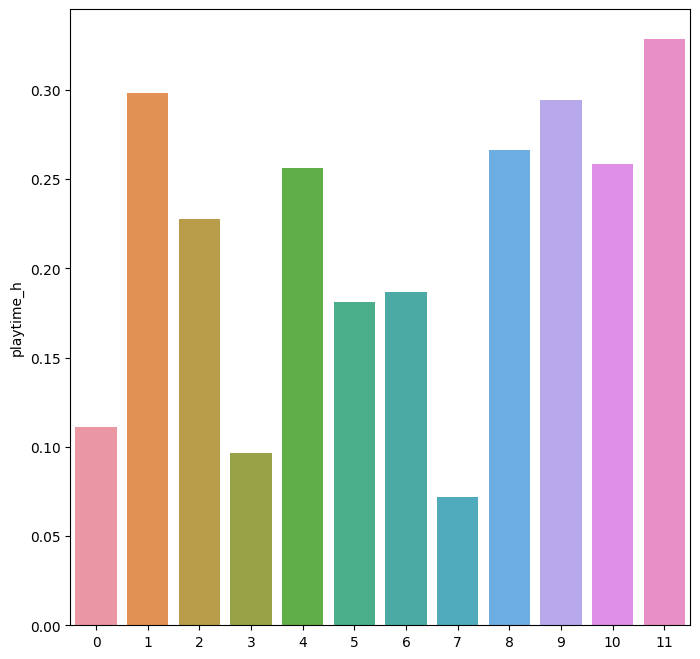

In [87]:
# How to control this for missing months? do october 25 2019 thru 2022
plt.rcParams['figure.figsize']=(8,8)
sns_prep = music_streams.query('year == 2019| year == 2020 | year == 2021')
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime_s",
    index=sns_prep.timestamp.dt.strftime("%b"),
    aggfunc="sum",
).reset_index()
sns_prep["playtime_h"] = sns_prep["playtime_s"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x=sns_prep.index, y="playtime_h")


In [ ]:
# sum of unique uris closely maps to total skips per month
sns_prep = music_streams.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


KeyError: "['duration_s'] not in index"

In [ ]:
# good way to find months with most music discovery along with unique URIs
sns_prep = music_streams.copy().query("(playtime_s / duration_s) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration_s", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"].astype(str)
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


In [ ]:
# def show_transformations(df, song, transformation="all"):
#     song_key = df.query("(id == @song)")["camelot"]
#     # print(song_key)
#     keys = wheel_df.loc[transformation, song_key].reset_index(drop=True)
#     # print(type(keys))
#     print(keys[0])
#     return df.query("camelot.isin(@keys[0])", engine="python")


# fuck = show_transformations(music_streams, "115RufHm0zvrPN3MaheZ98", ["major"])
# fuck
# # song_key = playlist_example.loc[1, "camelot"]
# # friendkey = wheel_df.loc["dominant_relative", song_key]
# # playlist_example.query("camelot in @friendkey")


In [ ]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    music_streams, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


In [ ]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
music_streams.query("(playtime_s / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


,artist,track,album,duration,playtime_s,date,time,dtime,ddate,day,month,year,tempo,camelot,key_signature,start,end,shuffle,id,timestamp
76670,2 Chainz,Birthday Song,Based On A T.R.U. Story,307,296,04/17/2022,05:53:28,05:53:28,2022-04-17,Sun,Apr,2022,140,3B,D-flat major,trackdone,trackdone,False,5qkWTBmDmZjogwIvbKtJQv,2022-04-17 05:53:28-05:00
12012,Trap Beckham,Birthday Bitch,Birthday Bitch,197,62,08/13/2021,03:02:48,03:02:48,2021-08-13,Fri,Aug,2021,102,8B,C major,playbtn,endplay,False,4ZFtNZuzzdHjYKARA8TEh2,2021-08-13 03:02:48-05:00
19369,Disclosure,Birthday,Birthday,220,121,08/13/2021,03:07:33,03:07:33,2021-08-13,Fri,Aug,2021,136,4A,F minor,fwdbtn,endplay,False,2jCSd2lOtWQKtwb7FdfvPQ,2021-08-13 03:07:33-05:00
29936,Happy Birthday,Happy Birthday Reggae,10 Happy Birthday Different Styles,98,29,08/13/2021,03:18:19,03:18:19,2021-08-13,Fri,Aug,2021,110,6B,B-flat major,playbtn,endplay,False,6ZEdAuCh2shaf3E3rrtHAp,2021-08-13 03:18:19-05:00
32918,Happy Birthday,Happy Birthday Funk,10 Happy Birthday Different Styles,82,51,08/13/2021,03:20:25,03:20:25,2021-08-13,Fri,Aug,2021,100,7B,F major,clickrow,endplay,True,2ShnbhqZMChTitBB2AQrVO,2021-08-13 03:20:25-05:00
60071,Happy Birthday,Happy Birthday Jazz,10 Happy Birthday Different Styles,110,23,08/13/2021,03:20:51,03:20:51,2021-08-13,Fri,Aug,2021,120,7B,F major,clickrow,endplay,True,4GeaHbsPgGR1xMPynrPvy5,2021-08-13 03:20:51-05:00
61743,Happy Birthday,Happy Birthday Country,10 Happy Birthday Different Styles,57,39,08/13/2021,03:24:08,03:24:08,2021-08-13,Fri,Aug,2021,78,8B,C major,clickrow,endplay,True,23X23yCXz1mjeDuRJPfTWm,2021-08-13 03:24:08-05:00
62631,Migos,Birthday,Culture III,227,27,08/13/2021,03:11:06,03:11:06,2021-08-13,Fri,Aug,2021,170,5A,C minor,playbtn,endplay,False,7tt5I7ztXfKzZRqyL2FCYb,2021-08-13 03:11:06-05:00
67625,Happy Birthday,Happy Birthday EDM,10 Happy Birthday Different Styles,65,53,08/13/2021,03:17:48,03:17:48,2021-08-13,Fri,Aug,2021,130,11B,A major,playbtn,endplay,False,4iP9axs07uXTxJiAr1l1rX,2021-08-13 03:17:48-05:00
69335,Twista,Birthday,Category F5,221,54,08/13/2021,03:16:30,03:16:30,2021-08-13,Fri,Aug,2021,110,3A,B-flat minor,playbtn,endplay,False,1tXZ25p92QkW2Oj7ElF4pA,2021-08-13 03:16:30-05:00


In [ ]:
# Todo: plot podcast listening vs music listening
# Totals per month
podcasts_2020 = podcasts.copy()
podcasts_2020["playtime_s"] = podcasts_2020["playtime_s"].copy() / 3600
podcast_per_month = podcasts_2020.groupby(by="month").sum(numeric_only=True)
podcast_per_month["playtime_s"]
sns.barplot(
    data=podcast_per_month, x=podcast_per_month["playtime_s"], y=podcast_per_month.index
)


In [ ]:
# Todo: plot podcast listening vs music listening
# damn i really spent most of january 2022 listening to podcats
# podm_gb = podm.groupby(by=podm.index).sum(numeric_only=True)

def plothpm(df_gb):
    sns.barplot(data=df_gb.iloc[0:0], x=df_gb.values, y=df_gb.index)

plothpm(hpm(no_skip_df))

In [ ]:
plothpm(hpm(music_streams))

In [ ]:
from main_data import unpickl
import pandas as pd
import numpy as np
import_all()
pod = podcasts.copy()

def custom_mean(df):
    return df.mean(skipna=True)

In [ ]:
# import_all()
#Todo: figure out which level of this 
pod = podcasts.copy()
pod.loc[:, "hours"] = podcasts.loc[:, "playtime_s"].copy() / 3600
pod.index = pod.timestamp
podm = pod.copy().loc[:,'hours'].resample("M").apply(lambda x: np.sum(x.values)).round()
podm_gb = podm.groupby(podm.index.strftime("%b")).resample("Y").apply(lambda x: np.sum(x.values)).round().droplevel(level=1)
podm_gb = podm_gb.groupby(podm_gb.index).mean()
podm_gb


In [ ]:
# avg per month

import matplotlib as plt
plt.rcParams['figure.figsize']=(8,8)
sns.barplot(data=podm_gb, x=podm_gb["hours"], y=podm_gb.index)

In [ ]:
def hpm(pod):
    #pod = podcasts.copy()
    pod.loc[:, "hours"] = pod.loc[:, "playtime_s"].copy() / 3600
    pod.index = pod.timestamp
    podm = pod.copy().loc[:,'hours'].resample("M").apply(lambda x: np.sum(x.values)).round()
    podm_gb = podm.groupby(podm.index.strftime("%b")).resample("Y").apply(lambda x: np.sum(x.values)).round().droplevel(level=1)
    podm_gb = podm_gb.groupby(podm_gb.index).mean()
    return podm_gb

podm_gb = hpm(podcasts)

In [ ]:
podm_gb